# Lesson 5 - Facial Similarity Search

### Import the Needed Packages

In [3]:
import sys
!{sys.executable} -m pip install --upgrade deepface

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 1.9 MB/s eta 0:00:0000:0100:010m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 1.7 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 1.9 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 1.7 MB/s eta 0:00:00
  Using cached wheel-0.42.0-py3-none-any.whl.metadata (2.2 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.7/151.7 kB 1.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.7/87.7 kB 1.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.3/101.3 kB 1.8 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
from deepface import DeepFace
from pinecone import Pinecone, ServerlessSpec
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from tqdm import tqdm
from DLAIUtils import Utils


import contextlib
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import time

24-02-06 09:57:39 - Directory /Users/ytchen/.deepface created
24-02-06 09:57:39 - Directory /Users/ytchen/.deepface/weights created


In [5]:
# get api key
utils = Utils()
PINECONE_API_KEY = utils.get_pinecone_api_key()

### Load the Dataset

**Note:** To access the dataset outside of this course, just copy the following two lines of code and run it (remember to uncomment them first before executing):

#!wget -q --show-progress -O family_photos.zip "https://www.dropbox.com/scl/fi/yg0f2ynbzzd2q4nsweti5/family_photos.zip?rlkey=00oeuiii3jgapz2b1bfj0vzys&dl=0"

#!unzip -q family_photos.zip

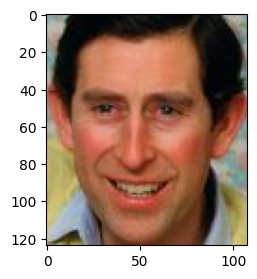

In [6]:
def show_img(f):
  img = plt.imread(f)
  plt.figure(figsize=(4,3))
  plt.imshow(img)

show_img('family/dad/P06260_face5.jpg')

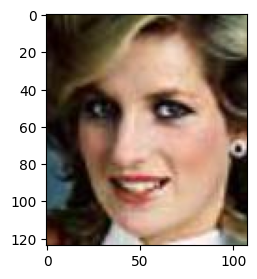

In [7]:
show_img('family/mom/P04407_face2.jpg')


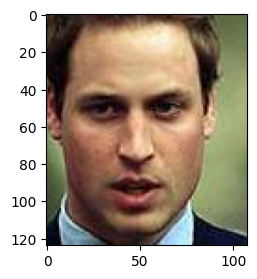

In [8]:
show_img('family/child/P04414_face1.jpg')


### Setup Pinecone 

In [9]:
MODEL = "Facenet"
INDEX_NAME = utils.create_dlai_index_name('dl-ai')

pinecone = Pinecone(api_key=PINECONE_API_KEY)

### Create Embeddings Using DeepFace

In [10]:
def generate_vectors():
  VECTOR_FILE = "./vectors.vec"

  with contextlib.suppress(FileNotFoundError):
    os.remove(VECTOR_FILE)
  with open(VECTOR_FILE, "w") as f:
    for person in ["mom", "dad", "child"]:
      files = glob.glob(f'family/{person}/*')
      for file in tqdm(files):
        try:
          embedding = DeepFace.represent(img_path=file, model_name=MODEL, enforce_detection=False)[0]['embedding']
          f.write(f'{person}:{os.path.basename(file)}:{embedding}\n')
        except (ValueError, UnboundLocalError, AttributeError) as e:
          print(e)

generate_vectors()

  0%|                                                                             | 0/78 [00:00<?, ?it/s]

24-02-06 09:59:12 - facenet_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/facenet_weights.h5
To: /Users/ytchen/.deepface/weights/facenet_weights.h5

  0%|                                                                        | 0.00/92.2M [00:00<?, ?B/s]
  1%|▎                                                               | 524k/92.2M [00:00<01:10, 1.30MB/s]
  1%|▋                                                              | 1.05M/92.2M [00:00<00:48, 1.86MB/s]
  2%|█                                                              | 1.57M/92.2M [00:00<00:46, 1.93MB/s]
  2%|█▍                                                             | 2.10M/92.2M [00:01<00:45, 1.96MB/s]
  3%|█▊                                                             | 2.62M/92.2M [00:01<00:45, 1.98MB/s]
  3%|██▏                                                            | 3.15M/92.2M [00:01<00:44, 1.98MB/s]
  4%|██▌                                                            | 3.67M/92.2M [00:01<00:44,

In [11]:
!head -10 vectors.vec

mom:P11987_face1.jpg:[-1.8463152647018433, 0.27299147844314575, 0.042532242834568024, -0.8764540553092957, 0.675710141658783, -0.13056010007858276, -0.34591731429100037, 1.7270901203155518, -0.6084272265434265, -0.29776236414909363, 1.378222107887268, -1.043375849723816, -1.0426675081253052, -0.142259880900383, 0.4242931306362152, -0.1743454486131668, 2.016960620880127, 0.3740176558494568, 0.44582298398017883, -1.238994836807251, -0.23586437106132507, -1.8841874599456787, 0.2602960467338562, 0.302554726600647, -0.40339094400405884, 0.24789071083068848, 0.23313793540000916, 0.5171542167663574, -1.2493091821670532, 0.17959441244602203, 0.2168470323085785, -0.781200110912323, -0.04206564277410507, 1.0673184394836426, 0.706771731376648, -0.4755876064300537, 1.167120099067688, 1.6654447317123413, -0.7330589890480042, -0.44103577733039856, -0.6169841289520264, -0.9232088923454285, 0.3781709671020508, 0.0004680156707763672, -0.3770521581172943, -0.5465396046638489, 0.3775852918624878, -0.9318

### Plot the Data of Images

In [12]:
def gen_tsne_df(person, perplexity):
    vectors =[]
    with open('./vectors.vec', 'r') as f:
      for line in tqdm(f):
        p, orig_img, v = line.split(':')
        if person == p:
            vectors.append(eval(v))
    pca = PCA(n_components=8)
    tsne = TSNE(2, perplexity=perplexity, random_state = 0, n_iter=1000,
        verbose=0, metric='euclidean', learning_rate=75)
    print(f'transform {len(vectors)} vectors')
    pca_transform = pca.fit_transform(vectors)
    embeddings2d = tsne.fit_transform(pca_transform)
    return pd.DataFrame({'x':embeddings2d[:,0], 'y':embeddings2d[:,1]})

In [13]:
def plot_tsne(perplexity, model):
    (_, ax) = plt.subplots(figsize=(8,5))
    #plt.style.use('seaborn-whitegrid')
    plt.grid(color='#EAEAEB', linewidth=0.5)
    ax.spines['top'].set_color(None)
    ax.spines['right'].set_color(None)
    ax.spines['left'].set_color('#2B2F30')
    ax.spines['bottom'].set_color('#2B2F30')
    colormap = {'dad':'#ee8933', 'child':'#4fad5b', 'mom':'#4c93db'}

    for person in colormap:
        embeddingsdf = gen_tsne_df(person, perplexity)
        ax.scatter(embeddingsdf.x, embeddingsdf.y, alpha=.5, 
                   label=person, color=colormap[person])
    plt.title(f'Scatter plot of faces using {model}', fontsize=16, fontweight='bold', pad=20)
    plt.suptitle(f't-SNE [perplexity={perplexity}]', y=0.92, fontsize=13)
    plt.legend(loc='best', frameon=True)
    plt.show()

241it [00:00, 13352.36it/s]


transform 70 vectors


241it [00:00, 15561.24it/s]


transform 93 vectors


241it [00:00, 18056.29it/s]


transform 78 vectors


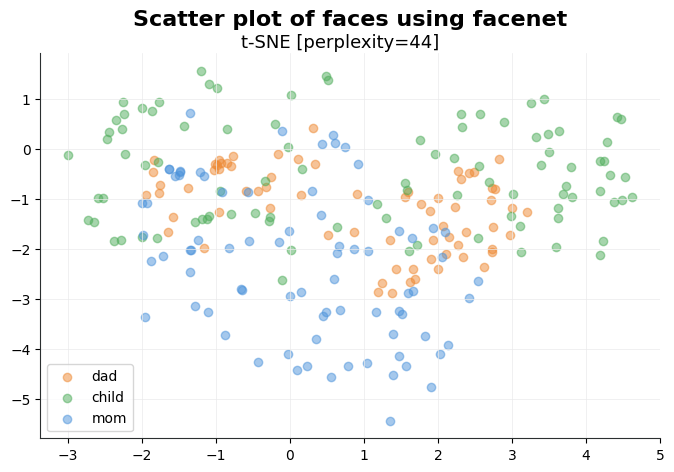

In [14]:
plot_tsne(44, 'facenet')

### Store the Embeddings in Pinecone

In [15]:
if INDEX_NAME in [index.name for index in pinecone.list_indexes()]:
  pinecone.delete_index(INDEX_NAME)
pinecone.create_index(name=INDEX_NAME, dimension=128, metric='cosine',
  spec=ServerlessSpec(cloud='aws', region='us-west-2'))

index = pinecone.Index(INDEX_NAME)

In [16]:
def store_vectors():
  with open("vectors.vec", "r") as f:
    for line in tqdm(f):
        person, file, vec = line.split(':')
        index.upsert([(f'{person}-{file}', eval(vec), {"person":person, "file":file})])
store_vectors()

241it [01:02,  3.85it/s]


In [17]:
index.describe_index_stats()

{'dimension': 128,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 241}},
 'total_vector_count': 241}

### Calculate the Similarity Scores

In [18]:
def test(vec_groups, parent, child):
  index = pinecone.Index(INDEX_NAME)
  parent_vecs = vec_groups[parent]
  K = 10
  SAMPLE_SIZE = 10
  sum = 0
  for i in tqdm(range(0,SAMPLE_SIZE)):
    query_response = index.query(
      top_k=K,
      vector = parent_vecs[i],
      filter={
        "person": {"$eq": child}
      }
    )
    for row in query_response["matches"]:
      sum  = sum + row["score"]
  print(f'\n\n{parent} AVG: {sum / (SAMPLE_SIZE*K)}')

In [19]:
def compute_scores():
  index = pinecone.Index(INDEX_NAME)
  vec_groups = {"dad":[], "mom":[], "child":[]}
  with open("vectors.vec", "r") as f:
    for line in tqdm(f):
      person, file, vec = line.split(':')
      vec_groups[person].append(eval(vec))
  print(f"DAD {'-' * 20}")
  test(vec_groups, "dad", "child")
  print(f"MOM {'-' * 20}")
  test(vec_groups, "mom", "child")

compute_scores()

241it [00:00, 4112.00it/s]


DAD --------------------


100%|████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.61it/s]




dad AVG: 0.4350530666099999
MOM --------------------


100%|████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.90it/s]



mom AVG: 0.3510760035999997


### Check the Matching Images

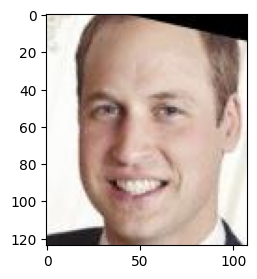

In [20]:
child_base = 'family/child/P06310_face1.jpg'
show_img(child_base)

In [21]:
#Now find closest given we know dad is "most similar"
embedding = DeepFace.represent(img_path=child_base, model_name=MODEL)[0]['embedding']
print(embedding)

[0.5283995866775513, 1.2861872911453247, -0.3561449348926544, -1.0126633644104004, 0.998287558555603, 0.6666178107261658, 0.5679249167442322, 1.606407642364502, 0.1469825804233551, -0.5307549834251404, 0.33921512961387634, -1.0853047370910645, -0.7407258152961731, -1.2022420167922974, -0.24404379725456238, -0.4366186857223511, -1.6220471858978271, -2.9247591495513916, -0.354549378156662, -0.24917516112327576, 0.03063492476940155, -0.2142203450202942, -0.4420772194862366, -0.3180325925350189, -0.4128818213939667, -0.3246872127056122, 1.1288138628005981, 0.46149736642837524, -0.8908529281616211, 0.5013224482536316, -1.8914422988891602, -0.10036219656467438, -2.0040078163146973, -0.5636593103408813, 0.4059144854545593, -0.580012321472168, -1.5189809799194336, -1.6227505207061768, 1.59950852394104, -0.3009597361087799, -0.9496647119522095, -1.9736138582229614, -2.546037197113037, -0.24491402506828308, 1.73477041721344, -1.626436710357666, 1.3015140295028687, 0.9842933416366577, 0.856539905

In [22]:
query_response = index.query(
      top_k=3,
      vector = embedding,
      filter={
        "person": {"$eq": "dad"}
      },
      include_metadata=True
)

In [23]:
print(query_response)


{'matches': [{'id': 'dad-P06396_face3.jpg',
              'metadata': {'file': 'P06396_face3.jpg', 'person': 'dad'},
              'score': 0.438557535,
              'values': []},
             {'id': 'dad-P11886_face3.jpg',
              'metadata': {'file': 'P11886_face3.jpg', 'person': 'dad'},
              'score': 0.419384599,
              'values': []},
             {'id': 'dad-P04408_face0.jpg',
              'metadata': {'file': 'P04408_face0.jpg', 'person': 'dad'},
              'score': 0.407050967,
              'values': []}],
 'namespace': '',
 'usage': {'read_units': 6}}


In [24]:
photo = query_response['matches'][0]['metadata']['file']


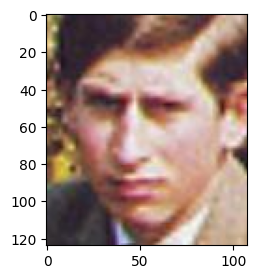

In [25]:
show_img(f'family/dad/{photo}')
